### 1. Develop a DMD model to forecast the future population states

#### Load data

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model
from scipy.integrate import solve_ivp
from scipy.interpolate import interp1d

import warnings
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv('data/table.csv')
df = df.set_index(['year'])
df.head()

,hare,lynx
year,,
1845,20,32
1847,20,50
1849,52,12
1851,83,10
1853,64,13


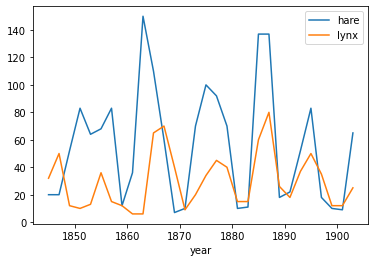

In [4]:
df.plot()

#### Prepare variables

In [5]:
years = df.index.values
x    = df.values
x

array([[ 20,  32],
       [ 20,  50],
       [ 52,  12],
       [ 83,  10],
       [ 64,  13],
       [ 68,  36],
       [ 83,  15],
       [ 12,  12],
       [ 36,   6],
       [150,   6],
       [110,  65],
       [ 60,  70],
       [  7,  40],
       [ 10,   9],
       [ 70,  20],
       [100,  34],
       [ 92,  45],
       [ 70,  40],
       [ 10,  15],
       [ 11,  15],
       [137,  60],
       [137,  80],
       [ 18,  26],
       [ 22,  18],
       [ 52,  37],
       [ 83,  50],
       [ 18,  35],
       [ 10,  12],
       [  9,  12],
       [ 65,  25]])

In [6]:
x.shape

(30, 2)

#### Optional interpolate

In [23]:
# def densify(t,y,dt):
    
#     f = interp1d(t, y, kind='cubic')
    
#     tnew = np.arange(t[0], t[-1], dt)
#     ynew = f(tnew)
#     return tnew, ynew

In [32]:
# years = df.index.values
# x1    = df['hare'].values
# x2    = df['lynx'].values

In [25]:
# dt = 0.1
# t, x1 = densify(years,x1, dt)
# t, x2 = densify(years,x2, dt)

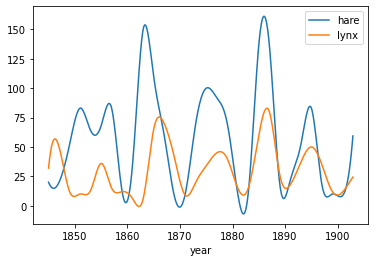

In [26]:
# df_new = pd.DataFrame({'year':t, 'hare':x1, 'lynx':x2}).set_index(['year'])
# df_new.plot();

In [38]:
# x = np.vstack([x1,x2])
# x = x.T
# x.shape

#### Optional run on one time series at a time

In [ ]:
# years = df.index.values
# x     = df.hare.values
# # x     = df.lynx.values
# x     = np.expand_dims(x, axis=1)

In [7]:
r   = 2
X1  = x[:-1].T
X2  = x[1:].T

#### Define DMD function 

In [9]:
def DMD(X,Xprime,r):
    
    # Step 1
    U,Sigma,VT = np.linalg.svd(X,full_matrices=0) 
    Ur = U[:,:r]
    Sigmar = np.diag(Sigma[:r])
    VTr = VT[:r,:]
    
    # Step 2
    Atilde = np.linalg.solve(Sigmar.T,(Ur.T @ Xprime @ VTr.T).T).T 
    
    # Step 3
    Lambda, W = np.linalg.eig(Atilde) 
    Lambda = np.diag(Lambda)
    
    # Step 4
    Phi = Xprime @ np.linalg.solve(Sigmar.T,VTr).T @ W 
    alpha1 = Sigmar @ VTr[:,0]
    b = np.linalg.solve(W @ Lambda,alpha1)
    
    return Phi, Lambda, b

In [10]:
Phi, Lambda, b = DMD(X1,X2,r)

In [11]:
b.shape

(2,)

In [12]:
b

array([-28.67853772,  52.50084268])

In [13]:
Lambda.shape

(2, 2)

In [14]:
Lambda

array([[0.7247559 , 0.        ],
       [0.        , 0.37843393]])

In [15]:
Phi.shape

(2, 2)

In [16]:
Phi

array([[-0.58132296,  0.06339913],
       [-0.43282183,  0.37308549]])

#### Forecast 10 time steps

In [17]:
omega = np.log(Lambda)/2

In [18]:
forecast = []

for i in np.arange(0,30,2):
    x = Phi @ np.exp(omega*i) * b
    forecast.append(x.flatten())
forecast = np.array(forecast)

In [19]:
forecast

array([[           nan,            nan,            nan,            nan],
       [1.20827624e+01, 1.25962022e+00, 8.99617548e+00, 7.41249992e+00],
       [8.75705336e+00, 4.76683026e-01, 6.52003126e+00, 2.80514144e+00],
       [6.34672609e+00, 1.80393029e-01, 4.72543112e+00, 1.06156069e+00],
       [4.59982718e+00, 6.82668420e-02, 3.42478408e+00, 4.01730578e-01],
       [3.33375189e+00, 2.58344890e-02, 2.48213247e+00, 1.52028480e-01],
       [2.41615635e+00, 9.77664709e-03, 1.79894015e+00, 5.75327343e-02],
       [1.75112357e+00, 3.69981494e-03, 1.30379249e+00, 2.17723385e-02],
       [1.26913714e+00, 1.40013549e-03, 9.44931299e-01, 8.23939153e-03],
       [9.19814629e-01, 5.29858770e-04, 6.84844534e-01, 3.11806528e-03],
       [6.66641079e-01, 2.00516534e-04, 4.96345117e-01, 1.17998168e-03],
       [4.83152055e-01, 7.58822592e-05, 3.59729052e-01, 4.46545101e-04],
       [3.50167303e-01, 2.87164212e-05, 2.60715753e-01, 1.68987815e-04],
       [2.53785819e-01, 1.08672680e-05, 1.88955280e

### 2. Do a time-delay DMD model to produce a forecast and compare with regular DMD. Determine if it is likely that there are latent variables.

In [21]:
X=df.hare.values
Y=df.lynx.values

from scipy.linalg import hankel

# Construct Hankel matrix
H_X = hankel(X)
H_Y = hankel(Y)

print(H_X.shape, H_Y.shape)

(30, 30) (30, 30)


21
20


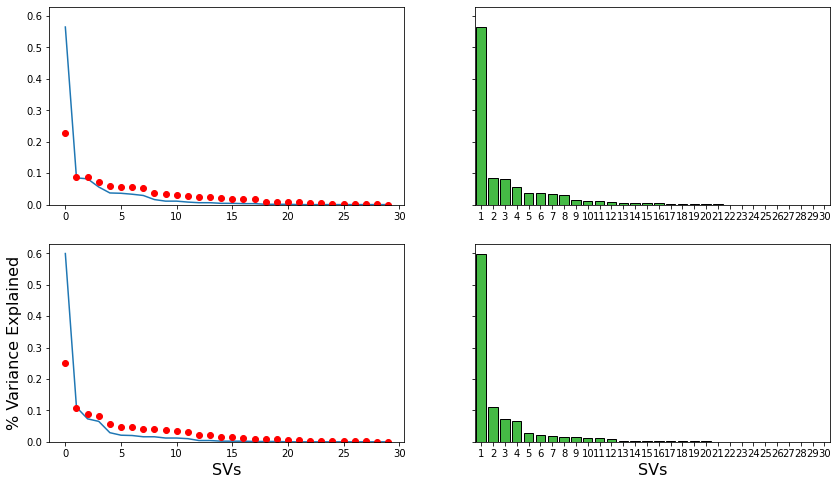

In [22]:
import seaborn as sns

# Take SVD of H_X
u, s, v = np.linalg.svd(H_X)
var_explained = np.round(s**2/np.sum(s**2), decimals=3)
print(len(var_explained[var_explained>0]))

fig, ax = plt.subplots(2, 2, figsize=(14, 8), sharey=True)
ax[0,0].plot(var_explained)
ax[0,0].plot(np.diag(np.diagflat(s)/np.sum(np.diagflat(s))), "ro");
ax[1,0].set_xlabel('SVs', fontsize=16)
ax[1,0].set_ylabel('% Variance Explained', fontsize=16)
sns.barplot(x=list(range(1,len(var_explained)+1)),
            y=var_explained, color="limegreen", ec='k', ax=ax[0,1])

# Take SVD of H_Y
u, s, v = np.linalg.svd(H_Y)
var_explained = np.round(s**2/np.sum(s**2), decimals=3)
print(len(var_explained[var_explained>0]))
ax[1,0].plot(var_explained)
ax[1,0].plot(np.diag(np.diagflat(s)/np.sum(np.diagflat(s))), "ro");


sns.barplot(x=list(range(1,len(var_explained)+1)),
            y=var_explained, color="limegreen", ec='k', ax=ax[1,1])
plt.xlabel('SVs', fontsize=16);

### 3. Empirical Predator-Prey models such as Lotka-Volterra are commonly used to model such phenomenon. Consider the model x ̇ = (b − py)x and y ̇ = (rx − d)y. Use the data to fit values of b, p, r and d.

#### Define function

In [23]:
def lotkavolterra(t, x0, b, p, d, r):
    x, y = x0
    return [b*x - p*x*y, -d*y + r*x*y]

#### Interpolate time series

In [24]:
years = df.index.values
x1    = df['hare'].values
x2    = df['lynx'].values

dt = 0.2
t, x1 = densify(years,x1, dt)
t, x2 = densify(years,x2, dt)

#### Plot initial dense data

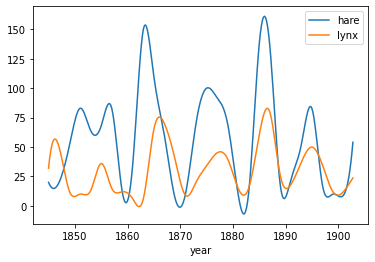

In [25]:
df_new = pd.DataFrame({'year':t, 'hare':x1, 'lynx':x2}).set_index(['year'])
df_new.plot();

#### Set up SINDy to get initial guess

In [26]:
def SINDy(x1s, x2s, Ax1s, Ax2s, dt):
    # compute derivative
    n = len(t)
    x1dots = []
    x2dots = []
    for j in range(1,n-1):
        x1dot = (x1[j+1] - x1[j-1]) / (2*dt) 
        x2dot = (x2[j+1] - x2[j-1]) / (2*dt)
        x1dots.append(x1dot)
        x2dots.append(x2dot)
    x1dots = np.array(x1dots)
    x2dots = np.array(x2dots)

    # run linear regression to find coefficients
    clf1 = linear_model.Lasso(alpha=0.001)
    clf1.fit(Ax1s.T, x1dots)
    clf2 = linear_model.Lasso(alpha=0.001)
    clf2.fit(Ax2s.T, x2dots)

    return clf1.coef_, clf2.coef_

#### Create matrix A from inner time series for each term

In [29]:
x1s = x1[1:-1]
x2s = x2[1:-1]
Ax1s = np.array([x1s, x1s*x2s])
Ax2s = np.array([x2s, x1s*x2s])

In [30]:
x1s = x1[1:-1]
x2s = x2[1:-1]
Ax1s = np.array([x1s, 
                 x1s*x2s])
                
Ax2s = np.array([x2s, 
                 x1s*x2s])

#### Run SINDy

In [31]:
clf1_coef, clf2_coef = SINDy(x1s, x2s, Ax1s, Ax2s, dt)

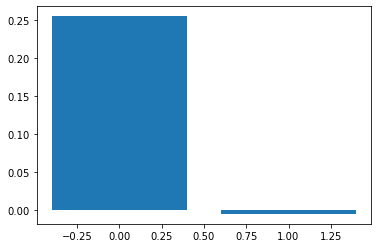

In [32]:
plt.bar(np.arange(len(clf1_coef)), clf1_coef);

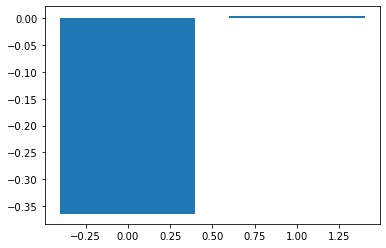

In [33]:
plt.bar(np.arange(len(clf2_coef)), clf2_coef);

#### Pull out coefficients

In [34]:
b, p, d, r = np.abs((clf1_coef[0], clf1_coef[1], clf2_coef[0], clf2_coef[1]))
b, p, d, r

(0.25537416681302194,
 0.005496395045871686,
 0.36435281521610596,
 0.003433344270585564)

#### Make prediction

In [35]:
t_range = [0, len(t)]
x0 = (x1[0], x2[0])
sol = solve_ivp(lotkavolterra, t_range, x0, args=(b, p, d, r), dense_output=True)

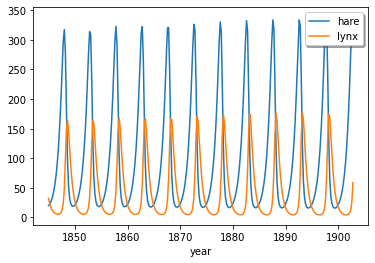

In [36]:
t = np.arange(0, len(t), 1)
pred_sindy_derived = sol.sol(t)

x = np.arange(years[0], years[-1], dt)
plt.plot(x, pred_sindy_derived.T)
plt.xlabel('year')
plt.legend(['hare', 'lynx'], shadow=True)
plt.show()

#### Compare with original

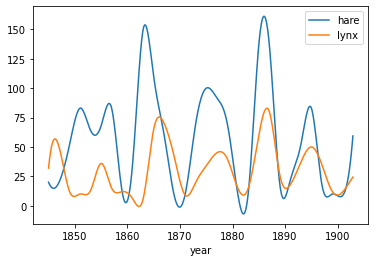

In [90]:
df_new.plot();

#### Best approximation after trial and error

In [39]:
b, p, d, r = 0.14, 0.005, 0.2, 0.0034 # best approximation after trial and error
b, p, d, r

(0.14, 0.005, 0.2, 0.0034)

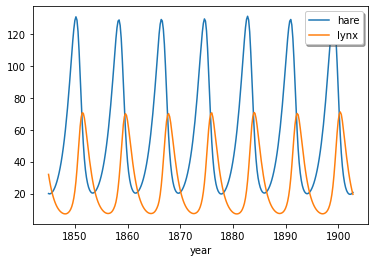

In [40]:
t_range = [0, len(t)]
x0 = (x1[0], x2[0])
sol = solve_ivp(lotkavolterra, t_range, x0, args=(b, p, d, r), dense_output=True)

t = np.arange(0, len(t), 1)
pred_estimated = sol.sol(t)

x = np.arange(years[0], years[-1], dt)
plt.plot(x, pred_estimated.T)
plt.xlabel('year')
plt.legend(['hare', 'lynx'], shadow=True)
plt.show()

#### Compare to original

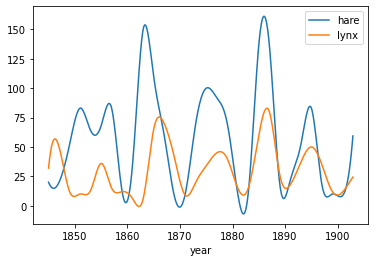

In [89]:
df_new.plot();

### 4. Find the best fit nonlinear, dynamical systems model to the data using sparse regression.

In [593]:
def lotkavolterra(t, x0, a):
    x, y = x0
    return [np.cos(t*.019) + np.sin(t*.06), np.cos(t*.04) - np.sin(t*.045)]

In [594]:
a = 2

In [595]:
t_range = [0, len(t)]
x0 = (x1[0], x2[0])
sol = solve_ivp(lotkavolterra, t_range, x0, args=(a,), dense_output=True)

In [596]:
clf1_coef, clf2_coef

(array([ 0.25795221, -0.00554451,  0.19047358,  0.63793962]),
 array([-0.36336746,  0.00342481,  0.0442043 , -0.45570879]))

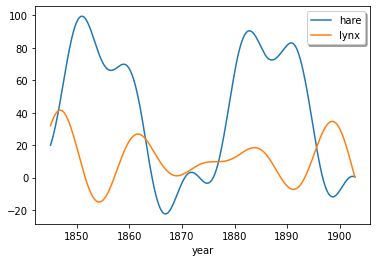

In [597]:
t = np.arange(0, len(t), 1)
pred_sindy_derived = sol.sol(t)

x = np.arange(years[0], years[-1], dt)
plt.plot(x, pred_sindy_derived.T)
plt.xlabel('year')
plt.legend(['hare', 'lynx'], shadow=True)
plt.show()

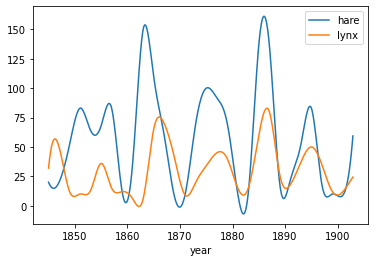

In [304]:
df_new.plot();

#### Create matrix A with non linear terms

In [166]:
x1s = x1[1:-1]
x2s = x2[1:-1]
Ax1s = np.array([x1s, x1s*x2s, np.cos(x1s), np.sin(x1s)])
Ax2s = np.array([x2s, x1s*x2s, np.cos(x2s), np.sin(x2s)])

#### Run SINDy

In [167]:
clf1_coef, clf2_coef = SINDy(x1s, x2s, Ax1s, Ax2s, dt)

In [341]:
clf1_coef, clf2_coef

(array([ 0.25795221, -0.00554451,  0.19047358,  0.63793962]),
 array([-0.36336746,  0.00342481,  0.0442043 , -0.45570879]))

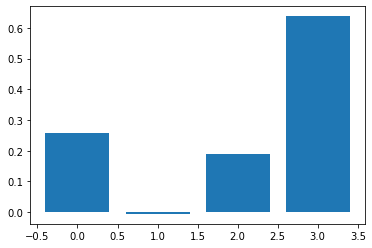

In [168]:
plt.bar(np.arange(len(clf1_coef)), clf1_coef);

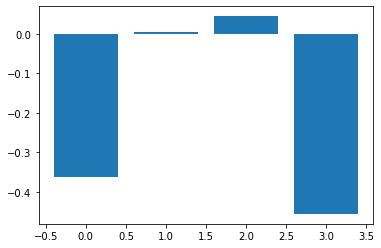

In [169]:
plt.bar(np.arange(len(clf2_coef)), clf2_coef);

#### Pull out coefficients

In [170]:
a,b,c,d = np.abs((clf1_coef[0], clf1_coef[1], clf1_coef[2], clf1_coef[3]))
e,f,g,h = np.abs((clf2_coef[0], clf2_coef[1], clf2_coef[2], clf2_coef[3]))

In [188]:
def lotkavolterra(t, x0, a,b,c,d, e,f,g,h):
    x, y = x0
    return [c*np.cos(t*x), g*np.sin(t*y)]

#### Make prediction

In [189]:
t_range = [0, len(t)]
x0 = (x1[0], x2[0])
sol = solve_ivp(lotkavolterra, t_range, x0, args=(a,b,c,d, e,f,g,h), dense_output=True)

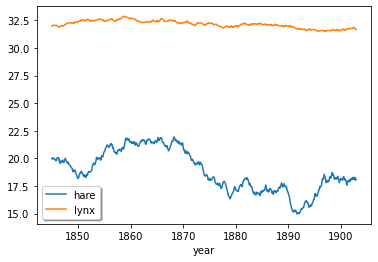

In [190]:
t = np.arange(0, len(t), 1)
pred_sindy_derived = sol.sol(t)

x = np.arange(years[0], years[-1], dt)
plt.plot(x, pred_sindy_derived.T)
plt.xlabel('year')
plt.legend(['hare', 'lynx'], shadow=True)
plt.show()

#### Compare with original

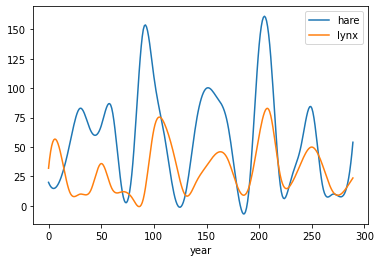

In [34]:
df_new = pd.DataFrame({'year':t, 'hare':x1, 'lynx':x2}).set_index(['year'])
df_new.plot();

### 5. Compute the KL divergence of the best model fit to the data between all the above models.

In [35]:
# adapted from https://gist.github.com/swayson/86c296aa354a555536e6765bbe726ff7
def kl(p, q):
    z = p * np.log(p / q)
    z = z[~np.isnan(z)]
    return np.sum(z)

In [36]:
p = pred_sindy_derived[0]
q = df_new.hare.values
kl(p, q)

37562.30870138051

In [37]:
p = pred_sindy_derived[1]
q = df_new.lynx.values
kl(p, q)

15406.070844542464

In [38]:
p = pred_estimated[0]
q = df_new.hare.values
kl(p, q)

10656.101067533062

In [39]:
p = pred_estimated[1]
q = df_new.lynx.values
kl(p, q)

3796.3312693234625

### 6. Retain three of your best fit models and compare their AIC and BIC scores.

In [40]:
from statsmodels.regression.linear_model import OLS
from statsmodels.tools import add_constant

regr = OLS(pred_sindy_derived[0], add_constant(df_new.hare.values)).fit()
print(regr.bic)
print(regr.aic)

3510.10459921777
3502.764837371809


In [41]:
regr = OLS(pred_sindy_derived[1], add_constant(df_new.lynx.values)).fit()
print(regr.bic)
print(regr.aic)

3119.474927847018
3112.135166001057


In [42]:
regr = OLS(pred_estimated[0], add_constant(df_new.hare.values)).fit()
print(regr.bic)
print(regr.aic)

2921.9754406840934
2914.635678838132


In [43]:
regr = OLS(pred_estimated[1], add_constant(df_new.lynx.values)).fit()
print(regr.bic)
print(regr.aic)

2600.326446434443
2592.9866845884817


### Download the data set BZ.mat (which is a snipet from a Belousov-Zhabotinsky chemical oscillator movie – check them out on youtube).


#### 1. get the data: download from the course website (It is next to HW 2)
#### 2. See what you can do with the data (i.e. repeat the first two steps above)  

The following code may be helpful for view the data.  

In [44]:
import h5py
import numpy as np
import matplotlib.animation as animation

In [45]:
f = h5py.File('./data/BZ.mat','r')
data = f.get('BZ_tensor')
data = np.array(data)

In [47]:
# fig = plt.figure()
# ims = []
# for i in data:
#     im = plt.imshow(i, animated=True)
#     ims.append([im])
# ani = animation.ArtistAnimation(fig, ims)
# ani.save('movie.gif', writer='ffmpeg')

In [ ]:
def DMD(X,Xprime,r):
    
    # Step 1
    U,Sigma,VT = np.linalg.svd(X,full_matrices=0) 
    Ur = U[:,:r]
    Sigmar = np.diag(Sigma[:r])
    VTr = VT[:r,:]
    
    # Step 2
    Atilde = np.linalg.solve(Sigmar.T,(Ur.T @ Xprime @ VTr.T).T).T 
    
    # Step 3
    Lambda, W = np.linalg.eig(Atilde) 
    Lambda = np.diag(Lambda)
    
    # Step 4
    Phi = Xprime @ np.linalg.solve(Sigmar.T,VTr).T @ W 
    alpha1 = Sigmar @ VTr[:,0]
    b = np.linalg.solve(W @ Lambda,alpha1)
    
    return Phi, Lambda, b

In [ ]:
plt.imshow(data[0])

In [ ]:
plt.imshow(data[1])

In [ ]:
X1       = data[0]
X1prime  = data[1]

In [ ]:
Phi, Lambda, b = DMD(X1,X1prime, 10)

In [ ]:
V2 = np.real(Phi)

# plt.hist(np.real(Phi).reshape(-1),128)
plt.hist(V2.reshape(-1),128)
plt.show()

In [ ]:
from pydmd import DMD

In [ ]:
dmd = DMD(svd_rank=3)
dmd.fit(X1.T)

In [ ]:
data[0].shape

In [ ]:
x = data[0].shape[1]
# t = data[0].shape[]

In [ ]:
for eig in dmd.eigs:
    print('Eigenvalue {}: distance from unit circle {}'.format(eig, np.abs(eig.imag**2+eig.real**2 - 1)))

dmd.plot_eigs(show_axes=True, show_unit_circle=True)

In [ ]:
# for mode in dmd.modes.T:
#     plt.plot(x, mode.real)
#     plt.title('Modes')
# plt.show()

# for dynamic in dmd.dynamics:
#     plt.plot(t, dynamic.real)
#     plt.title('Dynamics')
# plt.show()